# Read in the data

In [1]:
import pandas
import numpy
import re
import matplotlib.pyplot as plt

data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pandas.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

# Read in the surveys

In [2]:
all_survey = pandas.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pandas.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pandas.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_10", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns

In [3]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [4]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pandas.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pandas.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pandas.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [5]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [6]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pandas.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [7]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [8]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [9]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

# End of Imported Previous Work

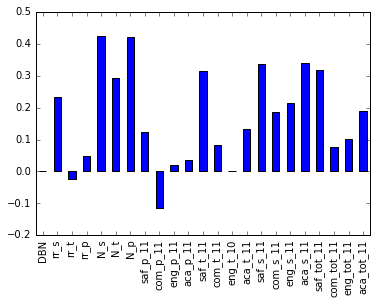

In [10]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

#%matplotlib inline #make plots inline
#combined.corr()["sat_score"][survey_fields].plot.bar()
#combined DataFrame, with a .corr() to find correlations
#correlations with ["sat_score"] and [survey_fields]
#.plot.bar

In [11]:
#print(combined.corr())
#this is all combinations of correlations

#print(combined.corr()["sat_score"].index)
#this is just the correlations between sat_score and each other field

print(combined.corr()["sat_score"][survey_fields])
#this is the correlation between sat_score and the columns in combined that
#have the same name as the strings in survey_fields

#DBN is in survey_fields but not in combined, and we get a NaN for the corr


DBN                NaN
rr_s          0.232199
rr_t         -0.023386
rr_p          0.047925
N_s           0.423463
N_t           0.291463
N_p           0.421530
saf_p_11      0.122913
com_p_11     -0.115073
eng_p_11      0.020254
aca_p_11      0.035155
saf_t_11      0.313810
com_t_11      0.082419
eng_t_10           NaN
aca_t_11      0.132348
saf_s_11      0.337639
com_s_11      0.187370
eng_s_11      0.213822
aca_s_11      0.339435
saf_tot_11    0.318753
com_tot_11    0.077310
eng_tot_11    0.100102
aca_tot_11    0.190966
Name: sat_score, dtype: float64


Some Notable Fields
======

## Higher Correlations
* rr_s: Student response rate
* N_s: Number of student respondents
* N_t: Number of teacher respondents
* N_p: Number of parent respondents
* saf_t_11: Safety and Respect score based on teacher responses
* saf_s_11: Safety and Respect score based on student responses
* aca_s_11: Academic expectations score based on student responses
* saf_tot_11: Safety and Respect total score

## Lower Correlations (nearest 0)
* rr_t: Teacher response rate
* rr_p: Parent response rate
* eng_p_11: Engagement score based on parent responses
* aca_p_11: Academic expectations score based on parent responses



The __higher correlating fields__ are not too unsurprising; high Safety and Respect scores would be expected to result in higher SAT scores. It is worth noting that the Safety and Respect scores of students and teachers correlate more highly than parent persepctives. 

There also appears to be a strong correlation between number of respondents and SAT scores, but the interesting point is that only the __student__ response rate had a high correlation to SAT score. This suggests that students willing to respond to these surveys are engaged and responsive (or at the very least, showing up to school and willing to fill out surveys), and one might expect these students to be more academically minded. 


The __low correlations__ are certainly a little more interesting and unexpected.  For instance, both teacher __and__ parent response rates had little to do with their students' SAT scores. On top of that, engagement and academic expectations from the parents' perspectives also had low correlations with SAT scores. This seems to go against the conventional idea that family engagement and pressure fosters a home environment conducive to learning. 

Perhaps there is more to the disparity between parent responses and SAT scores that is worth investigating. 

# Investigating Safety and SAT Scores

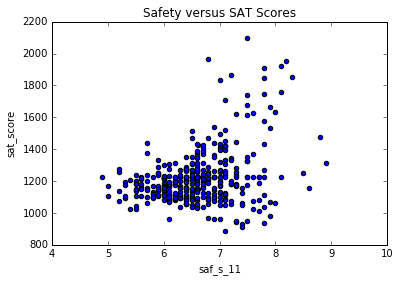

In [12]:
combined.plot.scatter("saf_s_11", "sat_score", title = "Safety versus SAT Scores")

There certainly appears to be a general trend between safety and SAT scores, although we don't have a the straight line of a strong correlation that we'd like to see. There are a few schools with high safety and low SAT scores, although there are no schools with low safety and high SAT scores.

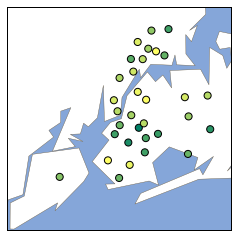

In [13]:
from mpl_toolkits.basemap import Basemap

#compute average safety score
#group combined by the school district, then do an agg with a mean
districts = combined.groupby("school_dist").agg(numpy.mean)

#make a Basemap
m = Basemap(
    projection = "merc",
    llcrnrlat = 40.496044,
    urcrnrlat = 40.915256,
    llcrnrlon = -74.255735,
    urcrnrlon = -73.700272,
    resolution = "i"
)

m.drawmapboundary(fill_color = "#85A6D9")
m.drawcoastlines(color = "#6D5F47", linewidth = 0.4)
m.drawrivers(color = "#6D5F47", linewidth = 0.4)
m.fillcontinents(color = "white", lake_color = "#85A6D9")

longitudes = districts["lon"].tolist()
latitudes = districts["lat"].tolist()
m.scatter(longitudes, latitudes, s = 50, zorder = 2, latlon = True, c = districts["saf_s_11"], cmap = "summer")
plt.show()

We see that the safest school districts tend to be in Brooklyn. Some parts of Manhattan and what looks to be Elmhurst/Jackson Heights are less safe in terms of the schools. The most northern district of the Bronx has a very safe district, although the rest of the Bronx seems to be on the less safe side. 

# Race and SAT Scores

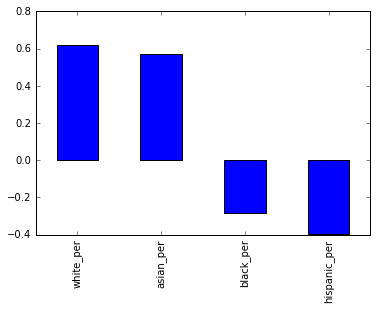

In [14]:
combined.corr()["sat_score"][["white_per", "asian_per", "black_per", "hispanic_per"]].plot.bar()

From the graph we see that there is a positive correlation between the percentage of white and asian students with SAT scores. On the other side, there is a negative correlation for black and Hispanic percentages with SAT scores. 

For the former, a higher percentage means a higher SAT score average for that high school. For the latter, the higher percertange means a lower SAT score average.

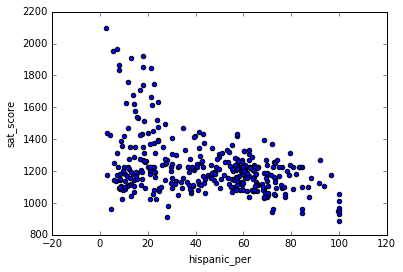

In [15]:
combined.plot.scatter("hispanic_per", "sat_score")

There appears to be a negative correlation between Hispanic percentage and SAT score (higher Hispanic percentage correlates to a lower average SAT score). However, there is a sizeable chunk of data points from 0 to about 70 percent Hispanic that sits steadily at around 1200 for the SAT. With such a large range of similar scores, the correlation is on the weak side.

## Schools With More Than 95% Hispanic Populations

In [20]:
his_95 = combined[combined["hispanic_per"] > 95.0]["SCHOOL NAME"]
print(his_95)

44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


In addition to being schools with 100% minority enrollment, all of these schools also have high percentages (90%+) of economically disadvantaged students. As we might expect, these schools teach either in Spanish or English and Spanish.

One thing of note is that the subject proficiencies and the college readiness of the students show some variance; these schools do not have entirely similar results despite very similar demographics.

## Schools With Less than 10% Hispanic Populations

In [21]:
his_10 = combined[combined["hispanic_per"] < 10.0]["SCHOOL NAME"]
print(his_10)

37                                STUYVESANT HIGH SCHOOL
46       HIGH SCHOOL FOR DUAL LANGUAGE AND ASIAN STUDIES
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
192                          BEDFORD ACADEMY HIGH SCHOOL
194                            BENJAMIN BANNEKER ACADEMY
220                           BOYS AND GIRLS HIGH SCHOOL
223    ACADEMY FOR COLLEGE PREPARATION AND CAREER EXP...
226               THE HIGH SCHOOL FOR GLOBAL CITIZENSHIP
227                         SCHOOL FOR HUMAN RIGHTS, THE
228                  SCHOOL FOR DEMOCRACY AND LEADERSHIP
229    HIGH SCHOOL FOR YOUTH AND COMMUNITY DEVELOPMEN...
230        HIGH SCHOOL FOR SERVICE & LEARNING AT ERASMUS
231    SCIENCE, TECHNOLOGY AND RESEARCH EARLY COLLEGE...
235              MEDGAR EVERS COLLEGE PREPARATORY SCHOOL
236                             CLARA BARTON HIGH SCHOOL
237                           IT TAKES A VILLAGE ACADEMY
238                           B

Despite small Hispanic populations at these schools, many of them still have high minority populations (70-100%), although the percentage of economically disadvantaged students varies much more dramatically. Additionally, the subject proficiency scores also vary widely with some schools having near 100% proficiency and some hovering around the 50% mark for Mathematics or English.

These variations are to be expected, because a small Hispanic population could mean predominantly white schools, predominantly black schools, predominantly Asian schools, or any variety of the three. Finding schools with small Hispanic populations is much more open-ended for the high school populations than finding schools with large Hispanic populations. This makes it harder for the results to be useful, although they can be compared with high Hispanic population percentages to see if there is a "Hispanic effect" at work (although jumping to conclusions here could prove foolish).

# Gender Differences in SAT Scores

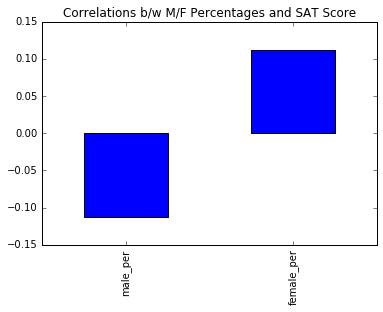

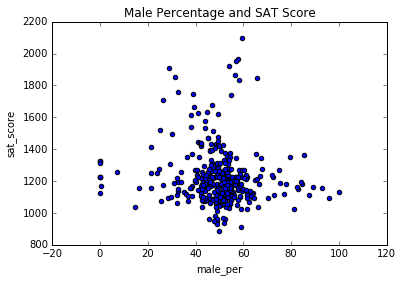

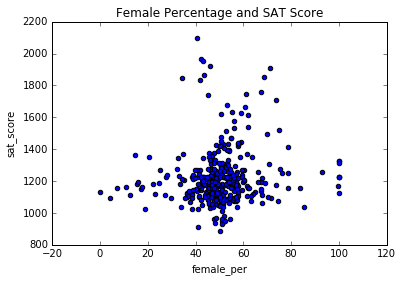

In [29]:
combined.corr()["sat_score"][["male_per", "female_per"]].plot.bar(title = "Correlations b/w M/F Percentages and SAT Score")

combined.plot.scatter("male_per", "sat_score", title = "Male Percentage and SAT Score")
combined.plot.scatter("female_per", "sat_score", title = "Female Percentage and SAT Score")

There are very slight correlations between both gender percentages and SAT score with a negative correlation for male percentage and a positive correlation for female percentage. However, the values hover around 0.10 which is not a strong correlation either way, and we would expect this result if males and females are generally equally apt at taking the SAT.

## Female Percentage and SAT Score

The highest SAT scores belong to schools where females are around 40% of the population, and another group of high scoring schools have around 70%. The schools with 100% female pouplation (all-girls schools) had average SAT scores and are in the same score area as the one all-boys school.

In [35]:
fem_60_1700 = combined[(combined["female_per"] > 60.0) & (combined["sat_score"] > 1700)]["SCHOOL NAME"]
print(fem_60_1700)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


All five of the schools have nearly 100% graduation rates and are nationally ranked by US News and World Report in some capacity. Although they vary a bit in racial and economic make-up, they are easily seen as academically competent schools.

# AP Scores and SAT Scores

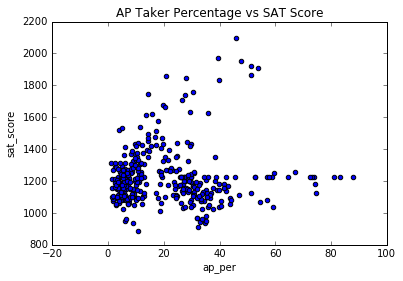

In [38]:
combined["ap_per"] = (combined["AP Test Takers "] / combined["total_enrollment"]) * 100

combined.plot.scatter("ap_per", "sat_score", title = "AP Taker Percentage vs SAT Score")

There appears to be a positive trend between AP Test Takers and SAT Scores. Oddly enough, there appears to be a straight, horizontal line at the 1200 SAT Score mark from 40% to about 90% for AP Test Takers. This looks to be more of an error with the data than a clear trend, and this would probably warrant further investigation into the dataset. Assuming it is correct, however, the positive correlation between percentage fo AP Test Takers and SAT Score is rather weak, which is definitely a surprising find.